In [1]:
#The purpose of this is to use an exon centric analysis:
#Take all exons and label as constitutive vs spliced 
#Associate exons with iCLIP binding to get the total

In [29]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)



In [3]:
#datasets to use for RT stops = mega dataframe_gene_expression_normalized_1nt
#this one has all of the information and is also normalized with gene calls to the highest expression in a given sample
clip_df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_1nt',sep='\t')

In [4]:
clip_df.head()

,cluster_id,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,...,external_gene_name,biotype,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
0,chr1:251639-251640,chr1,251639,251640,ENSG00000228463,0,-,6.521757,0.000000,7.521757,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,6.266323,0.000000,7.266323,1.000000,-2.861225
1,chr1:251646-251647,chr1,251646,251647,ENSG00000228463,0,-,2.898558,0.000000,3.898558,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,2.785032,0.000000,3.785032,1.000000,-1.920306
2,chr1:564514-564515,chr1,564514,564515,ENSG00000225972,0,+,0.000000,5.691002,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.208618,1.000000,1.208618,0.273358
3,chr1:564595-564596,chr1,564595,564596,ENSG00000225972,0,+,5.072477,0.000000,6.072477,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.524724,0.000000,1.524724,1.000000,-0.608548
4,chr1:564722-564723,chr1,564722,564723,ENSG00000225972,0,+,0.000000,19.349407,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.709300,1.000000,1.709300,0.773405


In [5]:
clip_df.columns.tolist()

['cluster_id',
 'chrom',
 'start',
 'end',
 'ens_gene',
 'blank',
 'strand',
 'hnM_DMSO',
 'hnM_TAM',
 'hnM_DMSO_1',
 'hnM_TAM_1',
 'log2ratio_TAM-DMSO',
 'gene',
 'gene_coords',
 'twist_d0_fpkm',
 'twist_d14_fpkm',
 'twist_d0_d14_fpkm_sum',
 'twist_d0_tpm',
 'twist_d14_tpm',
 'chr',
 'coords',
 'gene_length',
 'external_gene_name',
 'biotype',
 'twist_d0_fpkm_1',
 'twist_d14_fpkm_1',
 'log2ratio_fpkm_d14_d0',
 'hnM_DMSO_clip_gene_fpkm_norm',
 'hnM_TAM_clip_gene_fpkm_norm',
 'hnM_DMSO_clip_gene_fpkm_norm_1',
 'hnM_TAM_clip_gene_fpkm_norm_1',
 'log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm']

In [6]:
#Splicing library
#Description of ucsc known alt
# This track shows various types of alternative splicing and other events that result in more than a single transcript from the same gene. The label by an item describes the type of event. The events are:

# Alternate Promoter (altPromoter) - Transcription starts at multiple places. The altPromoter extends from 100 bases before to 50 bases after transcription start.
# Alternate Finish Site (altFinish) - Transcription ends at multiple places.
# Cassette Exon (cassetteExon) - Exon is present in some transcripts but not others. These are found by looking for exons that overlap an intron in the same transcript.
# Retained Intron (retainedIntron) - Introns are spliced out in some transcripts but not others. In some cases, particularly when the intron is near the 3' end, this can reflect an incompletely processed transcript rather than a true alt-splicing event.
# Overlapping Exon (bleedingExon) - Initial or terminal exons overlap in an intron in another transcript. These often are associated with incompletely processed transcripts.
# Alternate 3' End (altThreePrime) - Variations on the 3' end of an intron.
# Alternate 5' End (altFivePrime) - Variations on the 5' end of an intron.
# Intron Ends have AT/AC (atacIntron) - An intron with AT/AC ends rather than the usual GT/AG. These are associated with the minor spliceosome.
# Strange Intron Ends (strangeSplice) - An intron with ends that are not GT/AG, GC/AG, or AT/AC. These are usually artifacts of some sort due to sequencing error or polymorphism

#rmats splicing library
def getASEvents(asDir,): ## get AS events from GTF and SAM files
    logging.debug("getting AS events function..");

    samNames1=uniqSamNames(1);
    samNames2=uniqSamNames(2);
    finalSamNames = ','.join(samNames1)+','+','.join(samNames2);  
    if lite==1:
        finalSamNames = ','.join(samNames1); ## for the lite version

    #cmd = 'python '+binPath+'/processGTF.SAMs.py '+gtf+' '+asDir+'/fromGTF'+' '+finalSamNames+' '+libType+' '+tempPath;
    cmd = 'python '+binPath+'/processGTF.BAMs.py '+gtf+' '+asDir+'/fromGTF'+' '+finalSamNames+' '+libType+' '+SEPE+' '+str(novelSS) +' '+tempPath;
    #oFile.write('###### getting AS events from GTF and SAM files #####\n'+cmd+'\n#\n');
    oFile.write('###### getting AS events from GTF and BAM files #####\n'+cmd+'\n#\n');
    oFile.flush();
    status,output=commands.getstatusoutput(cmd);
    logging.debug("getting AS events is done with status %s" % status);
    if (int(status)!=0): ## it did not go well
        logging.debug("error in getting AS events %s" % status);
        logging.debug("error detail: %s" % output);
    raise Exception();
    logging.debug(output);

In [7]:
#add an id to each exon
with open('spliced_exon_analysis/hg19_v19_exons.bed') as f:
    counter = 1
    outlist = []
    for line in f:
        line = line.strip().split('\t')
        line[4] = "exon_"+str(counter)
        counter += 1
        outlist.append(line)
with open('spliced_exon_analysis/hg19_v19_exons_with_exon_id.bed','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(outlist)

In [94]:
%%time
#first step collect exons and associate with features
hg19_v19_exons = pd.read_csv('spliced_exon_analysis/hg19_v19_exons_with_exon_id.bed',sep='\t',names=['chrom','start','stop','ens_gene','exon_id','strand'])
#remove gene name stuff after ens_gene
hg19_v19_exons['ens_gene']=hg19_v19_exons.ens_gene.str.split('.').str[0]    
#read in gene names and biotypes
#I got this from ensembl biomart using the last GRCh37 archive - ENS version 75
hg19_grch37_gene_names_and_biotype = pd.read_csv('spliced_exon_analysis/ensembl_ens_gene_gene_name_biotype_grch37_p13',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#why are there duplicates?
hg19_grch37_gene_names_and_biotype.drop_duplicates(inplace=True)

#merge the exons with the gene names and biotypes
hg19_v19_exons = pd.merge(hg19_v19_exons,hg19_grch37_gene_names_and_biotype,on='ens_gene',how='left')
hg19_v19_exons.to_csv('spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes',sep='\t',header=False,index=False,na_rep='NaN')

#change the exon_id to something useful - combination of chrom,start_stop_ensgene_andexternal_gene_name
hg19_v19_exons['exon_id'] = hg19_v19_exons['chrom'].astype(str)+':'+hg19_v19_exons['start'].astype(str)+'-'+hg19_v19_exons['stop'].astype(str)+':'+hg19_v19_exons['strand'].astype(str)+':'+hg19_v19_exons['ens_gene'].astype(str)


#create a bedtools
hg19_v19_exons_bt = pbt.BedTool.from_dataframe(hg19_v19_exons,na_rep='NaN')


CPU times: user 3.85 s, sys: 136 ms, total: 3.98 s
Wall time: 3.99 s


In [95]:
%%time

#now I need to bring in the library of splice exons
#Lets try multiple sources - first use hg38 known alt
#first - hg38 known alt but lifted to hg19 - this has many more events - roughly double the number of cassette exons
#could also try the regular hg19 in case there are too many spliced exons
known_alt = pd.read_csv('/media/sam/Data1/annotations/splicing_libraries/knownAlt_hg19.bed',sep='\t',names=['chrom','start','end','splicing_type','score','strand'])
known_alt_bt = pbt.BedTool.from_dataframe(known_alt)
known_alt_cassette = known_alt[known_alt.splicing_type == "cassetteExon"]
known_alt_cassette_bt = pbt.BedTool.from_dataframe(known_alt_cassette).sort()

#intersect all of known alt with the hg19_v19_exons to find those that don't intersect with any known splicing event and are thus constitutive. also collect those that are alternative
hg19_v19_constitutive_exons = hg19_v19_exons_bt.intersect(b=known_alt_bt,s=True,v=True,wa=True)
hg19_v19_alternative_exons = hg19_v19_exons_bt.intersect(b=known_alt_bt,s=True,u=True,wa=True)
print((float(len(hg19_v19_alternative_exons))/float(len(hg19_v19_exons_bt))*100),'percent of exons are alternative')

#now figure out which alternative exons are cassette exons. intersect alternative with cassette 
#should i require a fraction of overlap? 
#should I require there be a perfect match or a partial match? Here I require a perfect reciprocal match
hg19_v19_alternative_cassette_exons = hg19_v19_alternative_exons.intersect(b=known_alt_cassette_bt,wa=True,s=True,u=True,f=1.0,r=True)
hg19_v19_alternative_non_cassette_exons = hg19_v19_alternative_exons.intersect(b=known_alt_cassette_bt,wa=True,s=True,v=True,f=1.0,r=True)

#focus on cassette exons to start
#in the dataframe label exons as alternative or not alternative and then cassette or non-cassette
header = ['chrom','start','end','ens_gene','exon_id','strand','external_gene_name','biotype']
hg19_v19_alternative_cassette_exons_df = hg19_v19_alternative_cassette_exons.to_dataframe(names=header)
hg19_v19_alternative_cassette_exons_df['alternative'] = 'yes'
hg19_v19_alternative_cassette_exons_df['splicing_type'] = 'cassette'

hg19_v19_alternative_non_cassette_exons_df = hg19_v19_alternative_non_cassette_exons.to_dataframe(names=header)
hg19_v19_alternative_non_cassette_exons_df['alternative'] = 'yes'
hg19_v19_alternative_non_cassette_exons_df['splicing_type'] = 'other'

hg19_v19_constitutive_exons_df = hg19_v19_constitutive_exons.to_dataframe(names=header)
hg19_v19_constitutive_exons_df['alternative'] = 'no'
hg19_v19_constitutive_exons_df['splicing_type'] = 'constitutive'

hg19_v19_exons_labeled_df = pd.concat([hg19_v19_alternative_cassette_exons_df,hg19_v19_alternative_non_cassette_exons_df,hg19_v19_constitutive_exons_df],ignore_index=True)
hg19_v19_exons_labeled_df.to_csv('spliced_exon_analysis/hg19_v19_exons_labeled_as_alternatively_spliced',sep='\t',index=False)

#bring back go bedtool
hg19_v19_exons_labeled_bt = pbt.BedTool.from_dataframe(hg19_v19_exons_labeled_df,na_rep='NaN')
hg19_v19_exons_labeled_bt_sorted = hg19_v19_exons_labeled_bt.sort()
hg19_v19_exons_labeled_bt_sorted.saveas('hg19_v19_exons_labeled_bt_sorted')

(18.167386921972, 'percent of exons are alternative')
CPU times: user 6.02 s, sys: 356 ms, total: 6.37 s
Wall time: 10.1 s


In [96]:
known_alt_cassette.head()

,chrom,start,end,splicing_type,score,strand
26,chr1,14969,15038,cassetteExon,0,-
33,chr1,17232,17368,cassetteExon,0,-
35,chr1,17258,17368,cassetteExon,0,-
37,chr1,17605,17742,cassetteExon,0,-
41,chr1,18267,18379,cassetteExon,0,-


In [97]:
#Something to note here:
#the total number of known_alt_cassette exons does not match the total number of hg19_v19_alternative_cassette_exons. I required that the hg19_known_alt match perfectly and reciprocally with the hg19_v19_exons

#This seems too large... I should try to filter this by what is actually expressed in the cell in terms of the transcript. But this could be a problem if we are looking for things associated with non-sense mediated decay
print(len(known_alt_cassette))
print(len(hg19_v19_alternative_cassette_exons))

31745
20295


In [98]:
#collect a dataframe of the RT stops for each sample
#I have the clip DF, which has the gene expression normalized value. Remember this is normalized binding for library divided by FPKM + 1. I will use this value for assigning binding. No need for length normalization at this point.
clip_normalized_binding_names = ['chrom','start','end','ens_gene','blank','strand','hnM_DMSO_clip_gene_fpkm_norm','hnM_TAM_clip_gene_fpkm_norm']
clip_normalized_binding_df = clip_df[clip_normalized_binding_names]
#for RT stops without gene expression correlate, just throw away by setting na_rep = 0
clip_normalized_binding_bt = pbt.BedTool.from_dataframe(clip_normalized_binding_df,na_rep=0.0)
# clip_normalized_binding_bt.saveas('clip_normalized_binding_bt')

In [99]:
#Now - I need to take the exons and associate with binding. 
#Strategy - I have the exons. Now I need to sum the binding within x nucleotides of the exon and see if it is higher for spliced vs non spliced exons on average. Make a boxplot.
#Tools - use bedtools intersect and then bedtools merge while summing

#Note, because of different exon size, I need to normalize the binding value based on total interval length. Just divide by the interval length at the end

#Another solution would be to just use intronic RT stops, but even then, if there are variable splice sites, some "intronic" reads will be considered exonic.

#slop the exons with a given interval. 
slop_length = 500
hg19_v19_exons_labeled_bt_sorted_slop = hg19_v19_exons_labeled_bt_sorted.slop(genome="hg19",b=slop_length)


#Intersect the slopped exons with the binding data
hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect = hg19_v19_exons_labeled_bt_sorted_slop.intersect(b=clip_normalized_binding_bt,s=True,wa=True,wb=True,sorted=True)

#Groupby and sum the proper columns - this is much better than merge - i should have thought of this
hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped = hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10],c=[17,18],o=["sum","sum"])

#Now I need to import into pandas for more work and boxplots
header = ['chrom','start','end','ens_gene','exon_id','strand','external_gene_name','biotype','alternative','splicing_type','hnM_DMSO_clip_fpkm_norm','hnM_TAM_clip_fpkm_norm']
intersect_df = hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped.to_dataframe(names=header)

#add a column for length
intersect_df['interval_length'] = intersect_df.end.astype('float')-intersect_df.start.astype('float')

#calculate length normalized binding
intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = intersect_df.hnM_DMSO_clip_fpkm_norm / intersect_df.interval_length
intersect_df['hnM_TAM_clip_fpkm_length_norm'] = intersect_df.hnM_TAM_clip_fpkm_norm / intersect_df.interval_length

#which pseudocounts to use - go off of minimums do 1e-8
pseudocount=1e-8
#calculate a fold change
intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)

#save the intersect_df
intersect_df.to_csv('spliced_exon_analysis/hg19_v19_exons_labeled_hnRNPM_clip_intersect',sep='\t',index=False)

In [100]:
epi = intersect_df[intersect_df.hnM_DMSO_clip_fpkm_length_norm > 0].hnM_DMSO_clip_fpkm_length_norm.min()
epi

3.0787952324195474e-07

In [101]:
mes = intersect_df[intersect_df.hnM_TAM_clip_fpkm_length_norm > 0].hnM_TAM_clip_fpkm_length_norm.min()
mes

2.8027835004325259e-07

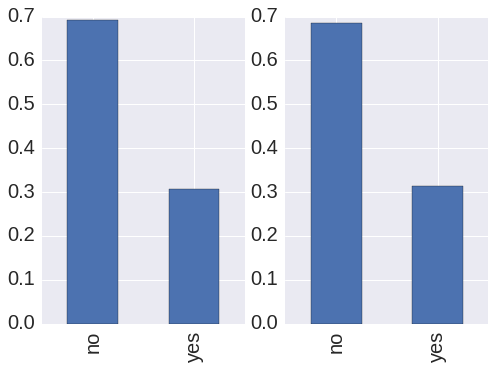

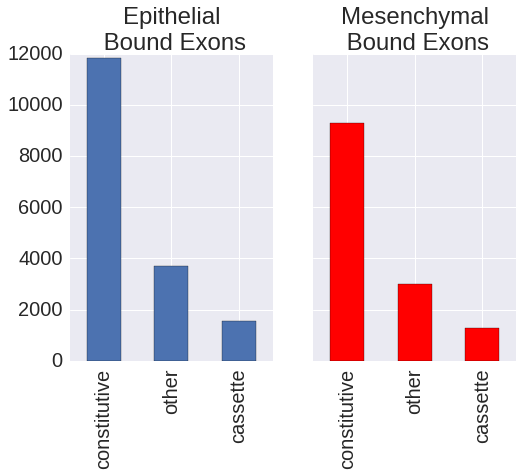

In [102]:
#Now lets groupby and plot boxplots different kinds.
#collect protein coding genes
intersect_df_protein_coding = intersect_df[intersect_df.biotype == "protein_coding"]

#collect by sample (require that value b > 0)
dmso = intersect_df_protein_coding[intersect_df_protein_coding.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = intersect_df_protein_coding[intersect_df_protein_coding.hnM_TAM_clip_fpkm_length_norm > 0]

#plot number of alternative to non_alternative exons bound
fig, axes = plt.subplots(nrows=1,ncols=2)
dmso.alternative.value_counts(normalize=True).plot(ax=axes[0],kind='bar',title='')
tam.alternative.value_counts(normalize=True).plot(ax=axes[1],kind='bar',title='')

#plot number of cassette exons out the alternative set
fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True)
dmso.splicing_type.value_counts(normalize=False).plot(ax=axes[0],kind='bar',title='Epithelial\n Bound Exons')
tam.splicing_type.value_counts(normalize=False).plot(ax=axes[1],kind='bar',title='Mesenchymal\n Bound Exons',color='r')

#sum the binding intensity for alternative vs. constitutive


('Epithelial Wilcoxon Cassette to Constitutive', RanksumsResult(statistic=8.2981874513886265, pvalue=1.0571178902290321e-16))
('Epithelial Wilcoxon Constitutive to Other', RanksumsResult(statistic=1.9651425921609487, pvalue=0.049397736155588332))
('Mesenchymal Wilcoxon Cassette to Constitutive', RanksumsResult(statistic=9.0147476523784622, pvalue=1.9732422577067676e-19))
('Mesenchymal Wilcoxon Constitutive to Other', RanksumsResult(statistic=3.9181395224258333, pvalue=8.9235052984667064e-05))


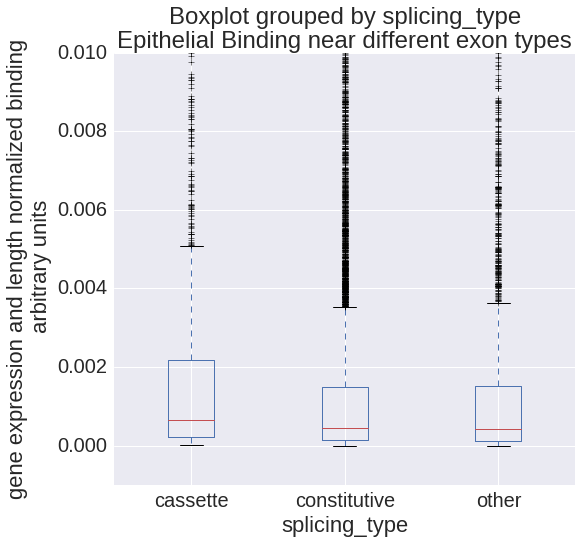

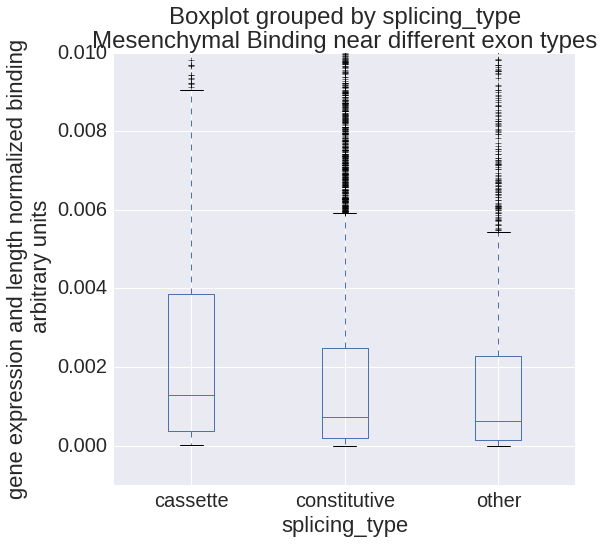

In [103]:
#Boxplots of binding
mpl.rc("lines", markeredgewidth=0.5)


fig = dmso.boxplot(by='splicing_type',column='hnM_DMSO_clip_fpkm_length_norm',fontsize=20,figsize=(8,8))
fig.set_ylim(top=0.01,bottom=-0.001)
fig.set_title('Epithelial Binding near different exon types')
fig.set_ylabel('gene expression and length normalized binding\n arbitrary units')
values_per_group = [col for col_name, col in dmso.groupby(by='splicing_type')['hnM_DMSO_clip_fpkm_length_norm']]
print('Epithelial Wilcoxon Cassette to Constitutive',ss.ranksums(values_per_group[0],values_per_group[1]))
print('Epithelial Wilcoxon Constitutive to Other',ss.ranksums(values_per_group[1],values_per_group[2]))

fig = tam.boxplot(by='splicing_type',column='hnM_TAM_clip_fpkm_length_norm',fontsize=20,figsize=(8,8))
fig.set_ylim(top=0.01,bottom=-0.001)
fig.set_title('Mesenchymal Binding near different exon types')
fig.set_ylabel('gene expression and length normalized binding\n arbitrary units')
values_per_group = [col for col_name, col in tam.groupby(by='splicing_type')['hnM_TAM_clip_fpkm_length_norm']]
print('Mesenchymal Wilcoxon Cassette to Constitutive',ss.ranksums(values_per_group[0],values_per_group[1]))
print('Mesenchymal Wilcoxon Constitutive to Other',ss.ranksums(values_per_group[1],values_per_group[2]))


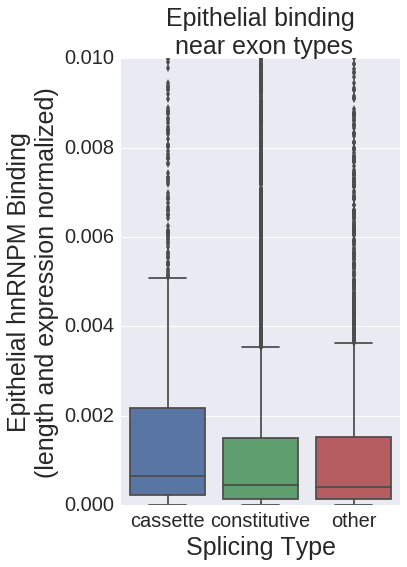

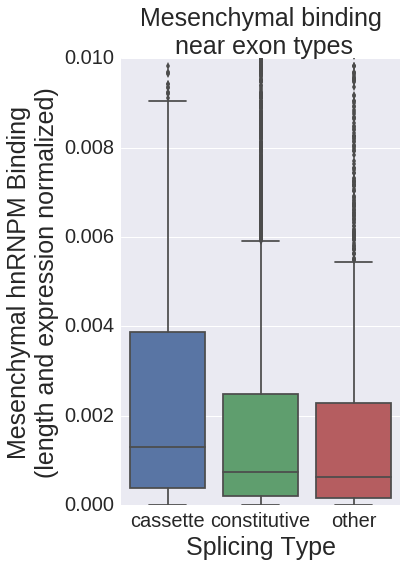

In [104]:
#Anna suggests that I try the violin plot from sns
#remember that all fo the data is stored in intersect df
import seaborn as sns
sns.set(font_scale=2)
sns.set_style(style='darkgrid')


#set biotype
intersect_df_biotype = intersect_df[intersect_df.biotype == "protein_coding"]

# intersect_df_biotype = intersect_df

#set the order of the names
cols = ['cassette','constitutive','other']

dmso = intersect_df_biotype[intersect_df_biotype.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = intersect_df_biotype[intersect_df_biotype.hnM_TAM_clip_fpkm_length_norm > 0]

plt.figure(figsize=(5,8))
plt.title('Epithelial binding\n near exon types',fontsize=25)
dmso_violin = sns.boxplot(x='splicing_type',y='hnM_DMSO_clip_fpkm_length_norm',data=dmso,order=cols)
dmso_violin.set_ylim(top=0.01,bottom=0)
dmso_violin.set_xlabel('Splicing Type',fontsize=25)
dmso_violin.set_ylabel('Epithelial hnRNPM Binding\n(length and expression normalized)',fontsize=25)
plt.show()


plt.figure(figsize=(5,8))
plt.title('Mesenchymal binding\n near exon types',fontsize=25)
tam_violin = sns.boxplot(x='splicing_type',y='hnM_TAM_clip_fpkm_length_norm',data=tam,order=cols)
tam_violin.set_ylim(top=0.02,bottom=-.005)
tam_violin.set_ylim(top=0.01,bottom=0)
tam_violin.set_xlabel('Splicing Type',fontsize=25)
tam_violin.set_ylabel('Mesenchymal hnRNPM Binding\n(length and expression normalized)',fontsize=25)
plt.show()


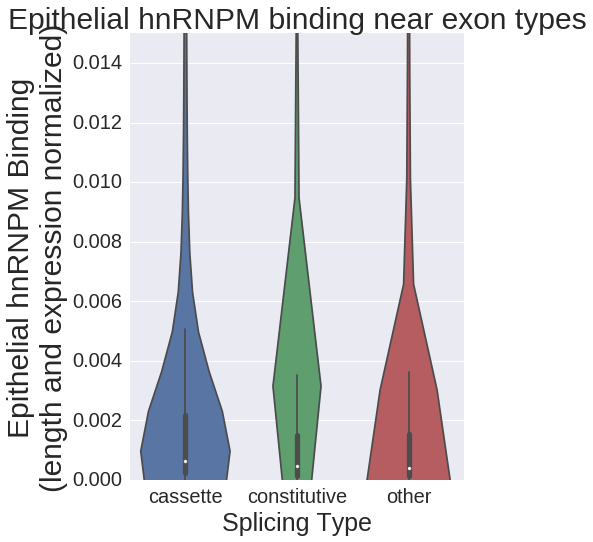

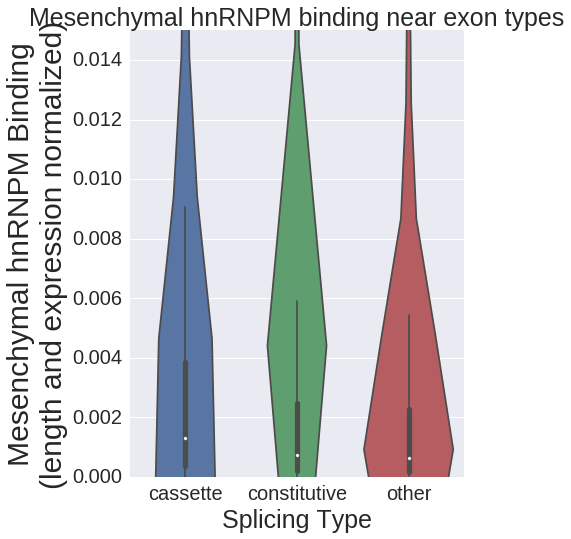

In [105]:
#Anna suggests that I try the violin plot from sns
#remember that all fo the data is stored in intersect df
import seaborn as sns
sns.set(font_scale=2)
sns.set_style(style='darkgrid')


#set biotype
intersect_df_biotype = intersect_df[intersect_df.biotype == "protein_coding"]

# intersect_df_biotype = intersect_df

#set the order of the names
cols = ['cassette','constitutive','other']

dmso = intersect_df_biotype[intersect_df_biotype.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = intersect_df_biotype[intersect_df_biotype.hnM_TAM_clip_fpkm_length_norm > 0]

plt.figure(figsize=(6,8))
plt.title('Epithelial hnRNPM binding near exon types',fontsize=30)
dmso_violin = sns.violinplot(x='splicing_type',y='hnM_DMSO_clip_fpkm_length_norm',data=dmso,order=cols)
dmso_violin.set_ylim(top=0.015,bottom=0)
dmso_violin.set_xlabel('Splicing Type',fontsize=25)
dmso_violin.set_ylabel('Epithelial hnRNPM Binding\n(length and expression normalized)',fontsize=30)
plt.show()


plt.figure(figsize=(6,8))
plt.title('Mesenchymal hnRNPM binding near exon types',fontsize=25)
tam_violin = sns.violinplot(x='splicing_type',y='hnM_TAM_clip_fpkm_length_norm',data=tam,order=cols)
tam_violin.set_ylim(top=0.015,bottom=0)
tam_violin.set_xlabel('Splicing Type',fontsize=25)
tam_violin.set_ylabel('Mesenchymal hnRNPM Binding\n(length and expression normalized)',fontsize=30)
plt.show()


In [106]:
#How many exons are showing up?
print(len(hg19_v19_exons_labeled_df))
print(len(hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped))
print(len(intersect_df))
print(len(intersect_df_protein_coding))

324422
23393
23393
21455


In [107]:
intersect_df.loc[intersect_df.external_gene_name == 'APLP2']

,chrom,start,end,ens_gene,exon_id,strand,external_gene_name,biotype,alternative,splicing_type,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio
4572,chr11,129939963,129941142,ENSG00000084234,chr11:129940463-129940642:+:ENSG00000084234,+,APLP2,protein_coding,yes,other,0.116208,0.056888,1179.0,0.000099,0.000048,-1.030346
4575,chr11,129970765,129971908,ENSG00000084234,chr11:129971265-129971408:+:ENSG00000084234,+,APLP2,protein_coding,no,constitutive,0.032538,0.000000,1143.0,0.000028,0.000000,-11.475600
4576,chr11,129971321,129972395,ENSG00000084234,chr11:129971821-129971895:+:ENSG00000084234,+,APLP2,protein_coding,no,constitutive,0.088318,0.000000,1074.0,0.000082,0.000000,-13.005673
4577,chr11,129979933,129981056,ENSG00000084234,chr11:129980433-129980556:+:ENSG00000084234,+,APLP2,protein_coding,yes,cassette,0.074373,0.000000,1123.0,0.000066,0.000000,-12.693424
4578,chr11,129993007,129994174,ENSG00000084234,chr11:129993507-129993674:+:ENSG00000084234,+,APLP2,protein_coding,yes,cassette,0.901773,0.268189,1167.0,0.000773,0.000230,-1.749472
4579,chr11,130003024,130004123,ENSG00000084234,chr11:130003524-130003623:+:ENSG00000084234,+,APLP2,protein_coding,no,constitutive,0.088318,0.032508,1099.0,0.000080,0.000030,-1.441617
4580,chr11,130004958,130006110,ENSG00000084234,chr11:130005458-130005610:+:ENSG00000084234,+,APLP2,protein_coding,yes,other,0.051131,0.000000,1152.0,0.000044,0.000000,-12.116180
4581,chr11,130006651,130007686,ENSG00000084234,chr11:130007151-130007186:+:ENSG00000084234,+,APLP2,protein_coding,yes,cassette,0.023242,0.000000,1035.0,0.000022,0.000000,-11.133503
4582,chr11,130008173,130010050,ENSG00000084234,chr11:130008673-130009550:+:ENSG00000084234,+,APLP2,protein_coding,yes,other,3.542015,0.755804,1877.0,0.001887,0.000403,-2.228458
4583,chr11,130009793,130010878,ENSG00000084234,chr11:130010293-130010378:+:ENSG00000084234,+,APLP2,protein_coding,no,constitutive,0.074373,0.000000,1085.0,0.000069,0.000000,-12.743079


In [108]:
#save a list of the protein_coding alternative exons with hnRNPM binding nearby within 500 bp

#first get alternative exons

intersect_df_alt = intersect_df[intersect_df.splicing_type == 'cassette']

#then get protein coding - don't do this, it doesn't matter and you don't want to exclude anything

# intersect_df_alt_protein_coding = intersect_df_alt[intersect_df_alt.biotype == 'protein_coding']

#save those with at least some binding in either condition

epi_intersect_df_alt = intersect_df_alt[intersect_df_alt.hnM_DMSO_clip_fpkm_length_norm > 0]

mes_intersect_df_alt = intersect_df_alt[intersect_df_alt.hnM_TAM_clip_fpkm_length_norm > 0]

#save those with enrichment

# epi_intersect_df_alt = intersect_df_alt[intersect_df_alt.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio < -1]

# mes_intersect_df_alt = intersect_df_alt[intersect_df_alt.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio > 1]

#save the epi_intersect_df_alt and mes_intersect_df_alt v_id

epi_intersect_df_alt.to_csv('../../find_nonsense_mediated_decay_genes/epi_cassette_intersect_df_500_bp_dataframe',sep='\t',index=False)

mes_intersect_df_alt.to_csv('../../find_nonsense_mediated_decay_genes/mes_cassette_intersect_df_500_bp_dataframe',sep='\t',index=False)




In [109]:
print(len(intersect_df),len(intersect_df_alt),len(intersect_df_alt_protein_coding))

(23393, 2034, 1968)


In [110]:
print(len(epi_intersect_df_alt),len(mes_intersect_df_alt))

(1605, 1321)


<matplotlib_venn._common.VennDiagram instance at 0x7f1c6a171320>

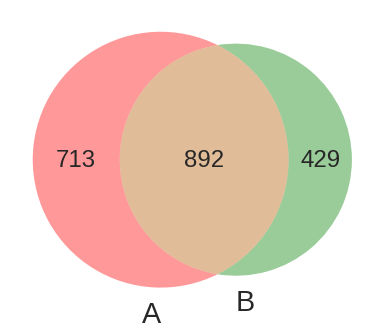

In [111]:
#overlap of alternative exons bound with any evidence... there are some distinctions. You may want to do those with enrichment
mplv.venn2([set(epi_intersect_df_alt.exon_id.tolist()),set(mes_intersect_df_alt.exon_id.tolist())])

In [114]:
epi_intersect_df_alt.exon_id.head()

38    chr1:1050402-1050455:-:ENSG00000131591
44    chr1:1200163-1200210:-:ENSG00000160087
45    chr1:1201478-1201670:-:ENSG00000160087
46    chr1:1203113-1203372:-:ENSG00000160087
55    chr1:1257288-1257364:-:ENSG00000127054
Name: exon_id, dtype: object